In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Patient filtering
do the following:
1. seperate case and control group based on their diagnosis code
2. get the observation/prediction window for each patient 
3. filter by number of events within observation and predicaiton window (number from 30 -500)
4. calculate demographic data for each group

In [76]:
with_time = False
if with_time:
    all_events = pd.read_csv('./cleaned_data/all_events_data_w_time.csv')
else:
    all_events = pd.read_csv('./cleaned_data/all_events_data.csv')

In [77]:
all_events.head()

,Unnamed: 0,EVENTS,SUBJECT_ID,TIME,EVE_INDEX
0,0,send 500mg vial,10,2103-06-28 00:00:00,4840
1,1,neo*iv*ampicillin sodium,10,2103-06-28 00:00:00,4081
2,2,###diagV30,10,2103-06-28 11:36:00,897
3,3,###diag765,10,2103-06-28 11:36:00,636
4,4,###diag765,10,2103-06-28 11:36:00,636


In [78]:
np.unique(all_events.SUBJECT_ID).shape

(46520,)

In [79]:
# event counts of all ids

all_count = all_events.groupby('SUBJECT_ID')['EVE_INDEX'].agg({'count':lambda x: len(x)})

In [80]:
all_count.reset_index(inplace=True)

In [81]:
all_count.head()

,SUBJECT_ID,count
0,2,8
1,3,15
2,4,71
3,5,4
4,6,161


In [82]:
all_count.describe()

,SUBJECT_ID,count
count,46520.000000,46520.000000
mean,34425.772872,108.503676
std,28330.400343,133.825438
min,2.000000,1.000000
25%,12286.750000,29.000000
50%,24650.500000,75.000000
75%,55477.500000,136.000000
max,99999.000000,2802.000000


In [83]:
# Control / Case group
case_id = pd.unique(all_events.ix[all_events['EVENTS'].str[:10] == '###diag428','SUBJECT_ID'])
control_id =np.setdiff1d(np.unique(all_events['SUBJECT_ID'].values),case_id)

In [84]:
case_id.shape

(10154,)

In [85]:
control_id.shape

(36366,)

### indentify case and control groups

In [86]:
control = all_events.ix[np.in1d(all_events['SUBJECT_ID'],control_id),:]
case = all_events.ix[np.in1d(all_events['SUBJECT_ID'],case_id),:]

In [87]:
control.head()

,Unnamed: 0,EVENTS,SUBJECT_ID,TIME,EVE_INDEX
0,0,send 500mg vial,10,2103-06-28 00:00:00,4840
1,1,neo*iv*ampicillin sodium,10,2103-06-28 00:00:00,4081
2,2,###diagV30,10,2103-06-28 11:36:00,897
3,3,###diag765,10,2103-06-28 11:36:00,636
4,4,###diag765,10,2103-06-28 11:36:00,636


In [88]:
np.unique(control.SUBJECT_ID).shape

(36366,)

In [89]:
np.unique(case.SUBJECT_ID).shape

(10154,)

### filter based on observation window for control group

In [90]:
observation_window = 2000

In [91]:
control_index_date = control.groupby(['SUBJECT_ID'], \
                    as_index=False)['TIME'].agg({'INDEX_DATE': lambda x: pd.to_datetime(x).max()})

In [92]:
control_filter = pd.merge(control,control_index_date,how='left',on = ['SUBJECT_ID'])

In [93]:
#observation window is set to be 2000 days
choice1 = pd.to_datetime(control_filter['TIME'])>= pd.to_datetime(control_filter['INDEX_DATE']) - pd.DateOffset(observation_window)
choice2 = pd.to_datetime(control_filter['TIME']) <= pd.to_datetime(control_filter['INDEX_DATE'])
control_filter = control_filter[choice1 & choice2]
control_filter.head()    

,Unnamed: 0,EVENTS,SUBJECT_ID,TIME,EVE_INDEX,INDEX_DATE
0,0,send 500mg vial,10,2103-06-28 00:00:00,4840,2103-07-06
1,1,neo*iv*ampicillin sodium,10,2103-06-28 00:00:00,4081,2103-07-06
2,2,###diagV30,10,2103-06-28 11:36:00,897,2103-07-06
3,3,###diag765,10,2103-06-28 11:36:00,636,2103-07-06
4,4,###diag765,10,2103-06-28 11:36:00,636,2103-07-06


(array([34661,  1414,   212,    44,    18,    12,     4,     0,     0,     1]), array([  1.00000000e+00,   2.71400000e+02,   5.41800000e+02,
         8.12200000e+02,   1.08260000e+03,   1.35300000e+03,
         1.62340000e+03,   1.89380000e+03,   2.16420000e+03,
         2.43460000e+03,   2.70500000e+03]))
87.296045757
61.0
105.569474006


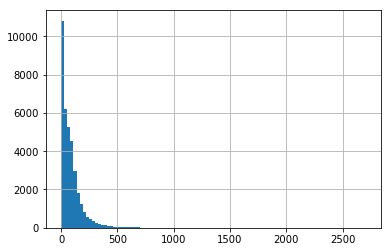

In [94]:
# control count
count_control = control_filter.groupby('SUBJECT_ID').apply(lambda x: x.EVE_INDEX.size)
count_control.hist(bins=100)
print(np.histogram(count_control))
print(np.mean(count_control)); print(np.median(count_control)); print(np.std(count_control))

In [95]:
# filter out control IDs with count >500 & count<30 ??
control_filter =pd.merge(control_filter, all_count,on='SUBJECT_ID',how='left')
control_filter_out = control_filter.ix[((control_filter['count']>30) & (control_filter['count']<500)),:]

In [96]:
np.unique(control_filter_out.SUBJECT_ID).shape

(24751,)

In [97]:
control_filter_out.head()

,Unnamed: 0,EVENTS,SUBJECT_ID,TIME,EVE_INDEX,INDEX_DATE,count
28,293,###diag285,10000,2186-08-10 21:57:00,215,2186-08-30,128
29,294,###diag303,10000,2186-08-10 21:57:00,233,2186-08-30,128
30,295,###diag276,10000,2186-08-10 21:57:00,206,2186-08-30,128
31,296,###proc389,10000,2186-08-10 21:57:00,1168,2186-08-30,128
32,297,###proc389,10000,2186-08-10 21:57:00,1168,2186-08-30,128


### filter based on observation window and prediction window for case group

In [98]:
prediction_window = 90

case_index_date = case.ix[case['EVENTS'].str[:10]=='###diag428',:].groupby(['SUBJECT_ID'], \
                        as_index=False)['TIME'].agg({'INDEX_DATE': \
                        lambda x: pd.to_datetime(x).min()- pd.Timedelta(days = prediction_window)})

In [99]:
case_index_date.head()

,SUBJECT_ID,INDEX_DATE
0,3,2101-07-22 19:08:00
1,9,2149-08-11 13:06:00
2,21,2134-06-13 12:17:00
3,26,2126-02-05 15:16:00
4,30,2172-07-16 14:17:00


In [100]:
case_filter = pd.merge(case,case_index_date,how='left',on = ['SUBJECT_ID'])

In [101]:
case_filter.head()

,Unnamed: 0,EVENTS,SUBJECT_ID,TIME,EVE_INDEX,INDEX_DATE
0,28,###proc960,1000,2144-01-19 20:15:00,1581,2143-10-21 20:15:00
1,29,###diag285,1000,2144-01-19 20:15:00,215,2143-10-21 20:15:00
2,30,###diag518,1000,2144-01-19 20:15:00,422,2143-10-21 20:15:00
3,31,###diag428,1000,2144-01-19 20:15:00,347,2143-10-21 20:15:00
4,32,###proc389,1000,2144-01-19 20:15:00,1168,2143-10-21 20:15:00


In [102]:
choice1 = pd.to_datetime(case_filter['TIME'])>= pd.to_datetime(case_filter['INDEX_DATE']) - pd.DateOffset(2000)
choice2 = pd.to_datetime(case_filter['TIME']) <= pd.to_datetime(case_filter['INDEX_DATE'])
case_filter = case_filter[choice1 & choice2]
case_filter.head()    

,Unnamed: 0,EVENTS,SUBJECT_ID,TIME,EVE_INDEX,INDEX_DATE
5821,14568,###proc361,10168,2110-12-02 14:57:00,1146,2110-12-06 20:50:00
5822,14569,###proc361,10168,2110-12-02 14:57:00,1146,2110-12-06 20:50:00
5823,14570,###diag424,10168,2110-12-02 14:57:00,343,2110-12-06 20:50:00
5824,14571,###diag414,10168,2110-12-02 14:57:00,335,2110-12-06 20:50:00
5825,14572,###diag427,10168,2110-12-02 14:57:00,346,2110-12-06 20:50:00


(array([735, 100,  22,   6,   2,   0,   1,   0,   0,   1]), array([  1.00000000e+00,   2.01500000e+02,   4.02000000e+02,
         6.02500000e+02,   8.03000000e+02,   1.00350000e+03,
         1.20400000e+03,   1.40450000e+03,   1.60500000e+03,
         1.80550000e+03,   2.00600000e+03]))
117.046136101
81.0
138.917765268


count     867.000000
mean      117.046136
std       138.997949
min         1.000000
25%        39.000000
50%        81.000000
75%       149.000000
max      2006.000000
dtype: float64

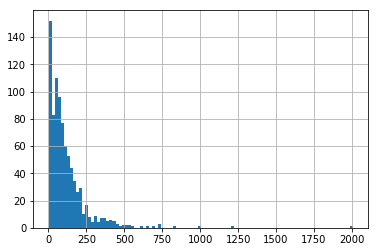

In [103]:
# case count
count_case = case_filter.groupby('SUBJECT_ID').apply(lambda x: x.EVE_INDEX.size)
count_case.hist(bins=100)
print(np.histogram(count_case))
print(np.mean(count_case)); print(np.median(count_case)); print(np.std(count_case))

count_case.describe()

In [104]:
# filter out <10 & > 1000???

case_filter =pd.merge(case_filter, all_count,on='SUBJECT_ID',how='left')
case_filter_out = case_filter.ix[((case_filter['count']>30) & (case_filter['count']<500)),:]

In [105]:
case_filter_out.head()

,Unnamed: 0,EVENTS,SUBJECT_ID,TIME,EVE_INDEX,INDEX_DATE,count
0,14568,###proc361,10168,2110-12-02 14:57:00,1146,2110-12-06 20:50:00,48
1,14569,###proc361,10168,2110-12-02 14:57:00,1146,2110-12-06 20:50:00,48
2,14570,###diag424,10168,2110-12-02 14:57:00,343,2110-12-06 20:50:00,48
3,14571,###diag414,10168,2110-12-02 14:57:00,335,2110-12-06 20:50:00,48
4,14572,###diag427,10168,2110-12-02 14:57:00,346,2110-12-06 20:50:00,48


In [106]:
np.unique(case_filter_out.SUBJECT_ID).size

682

In [107]:
case_filter_out.shape

(58179, 7)

## final output with filtered patients

In [108]:
# get sample from control
np.random.seed(6250)
sample_ids = np.random.choice(np.unique(control_filter_out.SUBJECT_ID),2*np.unique(case_filter_out.SUBJECT_ID).size,replace=False)

In [109]:
control_out = control_filter_out.ix[np.in1d(control_filter_out['SUBJECT_ID'],sample_ids),:]

In [110]:
np.unique(control_out.SUBJECT_ID).size

1364

In [111]:
control_out.reset_index(inplace=True)

In [112]:
if with_time:
    control_out.ix[:,['SUBJECT_ID','TIME','EVE_INDEX']].to_csv('./cleaned_data/control_w_time.csv')
    case_filter_out.ix[:,['SUBJECT_ID','TIME','EVE_INDEX']].to_csv('./cleaned_data/case_w_time.csv')
else:
    control_out.ix[:,['SUBJECT_ID','TIME','EVE_INDEX']].to_csv('./cleaned_data/control.csv')
    case_filter_out.ix[:,['SUBJECT_ID','TIME','EVE_INDEX']].to_csv('./cleaned_data/case.csv')

### calculate demographic information for control and case group

age, sex, and ethicities (in one-hot encoding)

In [113]:
demographic = pd.read_csv("./cleaned_data/demographic.csv",index_col = 0)

In [114]:
def get_demographic(data):
    demo = data.merge(demographic, how = "left", on = "SUBJECT_ID")
    demo = demo.ix[:, ["SUBJECT_ID", "INDEX_DATE", "GENDER", "DOB", "ETHNICITY"]].drop_duplicates()
    #calculate the age for the patients
    age = demo.INDEX_DATE - pd.to_datetime(demo.DOB)
    demo["AGE"] = age.apply(lambda x: x.days/365.25 +300 if x.days <0 else x.days/365.25)
    demo = demo.drop(["DOB", "INDEX_DATE"], axis = 1)
    demo_full = demo.merge(pd.get_dummies(demo.ETHNICITY), left_index= True, right_index= True)
    #gender 1 is M 0 is F
    demo_full.GENDER = demo_full.GENDER.apply(lambda x: 1 if x == "M" else 0)
    
    return demo_full.drop(["ETHNICITY"], axis = 1)

In [115]:
if with_time:
    control_demo = get_demographic(control_out)
    control_demo.to_csv('./cleaned_data/control_demo_wt.csv')
    case_demo = get_demographic(case_filter_out)
    case_demo.to_csv('./cleaned_data/case_demo_wt.csv')
else:
    control_demo = get_demographic(control_out)
    control_demo.to_csv('./cleaned_data/control_demo.csv')
    case_demo = get_demographic(case_filter_out)
    case_demo.to_csv('./cleaned_data/case_demo.csv')